## Image Focus and Astigmatism Classifier
**Author:** [Aaron Woods](https://aaronwoods.info)  
**Date Created:** September 12, 2023  
**Description:** This script provides an end-to-end machine learning pipeline to classify images as either "In Focus" or "Out of Focus", and additionally identifies astigmatism-related issues.  
**Repository:** [Image Classification on VSCode](https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification)

### Overview
The script features a comprehensive pipeline that ingests data from Excel spreadsheets and feeds it into various machine learning models. The design is modular, allowing for easy adaptability to address different image classification problems, including focus quality and astigmatism detection.


## Setup

In [756]:
# ------------------------------
# TensorFlow Installation with GPU Support
# ------------------------------
# Note: TensorFlow versions above 2.10 are not supported on GPUs on native Windows installations.
# For more details, visit: https://www.tensorflow.org/install/pip#windows-wsl2_1
# Uncomment the following line to install TensorFlow if needed.
# %pip install "tensorflow<2.11"

# ------------------------------
# System and TensorFlow Info Check
# ------------------------------
# Import necessary libraries and initialize an empty dictionary to store system information.
import platform
system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}

# Try importing TensorFlow and collecting relevant system information.
try:
    import tensorflow as tf
    system_info.update({
        "TensorFlow Version": tf.__version__,
        "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
    })
    system_info['Instructions'] = (
        "You're all set to run your model on a GPU." 
        if system_info['Num GPUs Available'] 
        else (
            "No GPUs found. To use a GPU, follow these steps:\n"
            "  1. Install NVIDIA drivers for your GPU.\n"
            "  2. Install a compatible CUDA toolkit.\n"
            "  3. Install the cuDNN library.\n"
            "  4. Make sure to install the GPU version of TensorFlow."
        )
    )
except ModuleNotFoundError:
    system_info['Instructions'] = (
        "TensorFlow is not installed. "
        "Install it using pip by running: !pip install tensorflow"
    )

# Format and display the gathered system information.
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)

Platform: Windows-10-10.0.22621-SP0
Python Version: 3.10.9
TensorFlow Version: 2.13.0
Num GPUs Available: 0
Instructions: No GPUs found. To use a GPU, follow these steps:
  1. Install NVIDIA drivers for your GPU.
  2. Install a compatible CUDA toolkit.
  3. Install the cuDNN library.
  4. Make sure to install the GPU version of TensorFlow.


In [757]:
# ------------------------------
# Package Installation (Optional)
# ------------------------------
# Uncomment the following lines to install required packages if running on a new machine.
# To suppress the output, we use '> /dev/null 2>&1'.
# %pip install numpy pandas matplotlib protobuf seaborn scikit-learn tensorflow > /dev/null 2>&1

# ------------------------------
# Import Libraries
# ------------------------------

# Standard Libraries
import os, sys, random, math, glob, logging
from datetime import datetime
from collections import defaultdict

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras.models import load_model
from tensorflow.data import Dataset

import pickle

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional


## Configuration

In [758]:
# Configuration dictionary
config = {
    'Experiment': {
        'NAME': "Multi-Label_Thresholds-30-60-1-2",  # Experiment name
        'RANDOM_SEED': 42,  # Seed for reproducibility
        'PROBLEM_TYPE': 'Multi-Class',  # Problem type: Binary, Multi-Class, Multi-Label
    },
    'Model': {
        'IMG_SIZE': 224,  # Image input size
        'BATCH_SIZE': 32,  # Batch size for training
        'EPOCHS': 100,  # Number of epochs
        'LEARNING_RATE': 1e-3,  # Learning rate
        'EARLY_STOPPING_PATIENCE': 5,  # Early stopping patience parameter
        'REDUCE_LR_PATIENCE': 3,  # Learning rate reduction patience parameter
        'MIN_LR': 1e-6,  # Minimum learning rate
        'LOSS': "binary_crossentropy",  # Loss function: "categorical_crossentropy" for multi-class
        'TRAIN_SIZE': 0.8,  # Fraction of data to use for training
        'VAL_SIZE': 0.5,  # Fraction of data to use for validation
    },
    'Labels': {
        'MAPPINGS': {  # Class label mappings
            'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
            'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
            'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
        }
    },
    'Augmentation': {  # Data augmentation parameters
        'rotation_factor': 0.002,
        'height_factor': (-0.18, 0.18),
        'width_factor': (-0.18, 0.18),
        'contrast_factor': 0.5,
    }
}


In [759]:
# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

### Recommendations for Loss Functions and Other Settings Per Problem Type

#### Multi-Label Problems:
- **Loss Function**: Typically, "binary_crossentropy" is used because each class label is independent and the task is to predict whether it is present or not.
- **Label Encoding**: One-hot encoding is commonly used where each label is considered as a separate class.
- **Activation Function**: The sigmoid activation function is generally used in the output layer to allow for multiple independent classes.
- **Evaluation Metrics**: Precision, Recall, and F1 Score can be effective for evaluating multi-label problems.

#### Binary Classification Problems:
- **Loss Function**: "binary_crossentropy" is the standard loss function because the task is to categorize instances into one of the two classes.
- **Label Encoding**: Labels are often encoded as 0 or 1.
- **Activation Function**: The sigmoid activation function is usually used in the output layer, producing a probability score that can be thresholded to yield a class label.
- **Evaluation Metrics**: Accuracy, Precision, Recall, and AUC-ROC are commonly used metrics.

#### Multi-Class Problems:
- **Loss Function**: "categorical_crossentropy" or "sparse_categorical_crossentropy" is commonly used. The former requires one-hot encoded labels, while the latter requires integer labels.
- **Label Encoding**: One-hot encoding is often used to convert the categorical labels into a format that can be provided to the neural network.
- **Activation Function**: The softmax activation function is used in the output layer to produce a probability distribution over the multiple classes.
- **Evaluation Metrics**: Accuracy is the most straightforward metric. However, Precision, Recall, and F1 Score can also be used for imbalanced datasets.

Remember to refer to these guidelines when setting up your configuration for different types of problems.


## Load and Preprocess the data

### Functions for Preparation of CSV

In [760]:
# Read the data

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df

def clean_csv(df: pd.DataFrame) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    invalid_rows = []
    removal_reasons = defaultdict(int)  # Dictionary to count reasons for removal
    for index, row in df.iterrows():
        image_path = row['ImageFile']
        reason = None  # Initialize removal reason as None
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        if reason:
            removal_reasons[reason] += 1  # Count the reason for removal
            invalid_rows.append(index)
    # Drop invalid rows
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    # Print summary of removal reasons
    print("Summary of row removals:")
    for reason, count in removal_reasons.items():
        print(f"{count} rows removed due to: {reason}")
    return df


### Generating labels

In [761]:
# Generating labels

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_multi_labels(df_copy, label_keys):
    df_copy['Multi_Labels'] = df_copy.apply(lambda row: [row[key] for key in label_keys], axis=1)
    mlb = MultiLabelBinarizer()
    df_copy['Multi_Labels_Binarized'] = list(mlb.fit_transform(df_copy['Multi_Labels']))
    return mlb.classes_

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}
    mlb_classes = None

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') != 'Multi-Label':
        return df_copy, label_encoders
    mlb_classes = generate_multi_labels(df_copy, labels_config.keys())
    print("---> Multi-labels generated.")
    return df_copy, mlb_classes

### Shuffling and Splitting the Data

In [762]:
# Shuffling and Splitting the data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

### Computting Class Weights

In [763]:
# Compute class weights

def compute_multi_label_class_weights(split, df, mlb, all_records):
    label_column = np.array(df['Multi_Labels'].tolist())
    binarized_labels = mlb.transform(label_column)
    for label_idx, label_name in enumerate(mlb.classes_):
        label_data = binarized_labels[:, label_idx]
        unique_labels = np.unique(label_data)
        class_weights = compute_class_weight('balanced', classes=unique_labels, y=label_data)
        class_weights_dict = dict(zip(unique_labels, class_weights))
        for cls, weight in class_weights_dict.items():
            cnt = Counter(label_data)[cls]
            all_records.append({'split': split, 'label': label_name, 'class': cls, 'Count': cnt, 'Weight': weight})

def compute_multi_class_class_weights(split, df, label, label_encoders, all_records):
    unique_labels = df[label].unique()
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=df[label])
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(df[label])[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_and_store_class_weights(datasets: Dict[str, pd.DataFrame], label_encoders: Dict[str, LabelEncoder], mlb_classes: np.ndarray = None) -> pd.DataFrame:
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    all_records = []
    if problem_type == 'Multi-Label':
        mlb = MultiLabelBinarizer(classes=mlb_classes)
        for split, df in datasets.items():
            if df is None:
                continue
            compute_multi_label_class_weights(split, df, mlb, all_records)
    else:
        for split, df in datasets.items():
            if df is None:
                continue
            # for label in config['Labels']['MAPPINGS']:
            #     compute_multi_class_class_weights(split, df, label, label_encoders, all_records)
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights


### Creating Tensorflow Datasets

In [764]:
# Create TensorFlow datasets

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame]) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    
    Parameters:
    - dfs: Dictionary containing DataFrames for 'train', 'val', and 'test'.
    
    Returns:
    - Dictionary containing TensorFlow datasets for each split.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create preprocessing and augmentation layers
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()

    # Initialize output dictionary
    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}

    # def load_and_preprocess_image(file_path, label, augment=False):
    #     file_path_str = file_path.numpy().decode('utf-8')
    #     image = read_and_convert_image(file_path_str)
    #     image = preprocessing_layers(image)
    #     if augment:
    #         image = augmentation_layers(image)
    #         image = tf.clip_by_value(image, 0.0, 1.0)
    #     return image, label
    def load_and_preprocess_image(file_path, label, offset, augment=False):
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        return image, label, offset

    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'
    }
    for split, df in dfs.items():
        if problem_type in ['Multi-Class', 'Binary']:
            augment_data = (split == 'train')
            # Create separate datasets for each label column
            # for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
            #     ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, df[label].values))
            #     ds = ds.map(lambda file_path, label: tf.py_function(func=load_and_preprocess_image, inp=[file_path, label, augment_data], Tout=[tf.float32, label.dtype]))
            #     ds = ds.batch(batch_size)
            #     ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
            #     tf_datasets[split][label] = ds

            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)  # Get the corresponding offset column
                ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, df[label].values, df[offset_column].values))
                ds = ds.map(lambda file_path, label, offset: tf.py_function(func=load_and_preprocess_image, inp=[file_path, label, offset, augment_data], Tout=[tf.float32, label.dtype, offset.dtype]))
                ds = ds.batch(batch_size)
                ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
                tf_datasets[split][label] = ds

        elif problem_type == 'Multi-Label':
            # Create a single dataset for multi-label classification
            ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values))
            ds = ds.map(lambda file_path, label: tf.py_function(func=load_and_preprocess_image, inp=[file_path, label, augment_data], Tout=[tf.float32, label.dtype]))
            ds = ds.batch(batch_size)
            ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
            tf_datasets[split]['Multi_Label'] = ds

        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets

# Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)


### Main Function for Data Preparation

In [765]:
# Configure for dataset creation

csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,  # Lower focus threshold
        'FOCUS_HIGH': 60,  # Upper focus threshold
        'STIGX_LOW': 1,  # Lower astigmatism threshold
        'STIGX_HIGH': 2,  # Upper astigmatism threshold
        'STIGY_LOW': 1,  # Lower astigmatism threshold
        'STIGY_HIGH': 2,  # Upper astigmatism threshold
    },
    'Paths': {  # Data and model paths
        'DATA_FILE': "combined_output.csv",
        'OLD_BASE_PATH': "D:\\DOE\\",
        # 'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\",
        # 'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Documents\\GitHub\\Image-Classification\\",
        'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\",
    },
    'SAMPLE_FRAC': 1.0,  # Fraction of the data to use for quicker prototyping. 1.0 means use all data.
}
config.update(csv_config)

# Change Global's PROBLEM_TYPE
config['Experiment']['PROBLEM_TYPE'] = 'Binary'
config['Experiment']['PROBLEM_TYPE'] = 'Multi-Class'
# config['Experiment']['PROBLEM_TYPE'] = 'Multi-Label'

# Main function to integrate all steps
def main_pipeline(config: Dict):
    print("===== Preprocessing CSV Data =====")
    data = read_csv(config)
    data = update_image_paths(data)
    data = clean_csv(data)
    data, label_encoders = generate_labels(data)
    data = shuffle_and_reset_index(data)
    print("===== Preparing TensorFlow Datasets =====")
    datasets = prepare_datasets(data)
    # info = compute_and_store_class_weights(datasets, label_encoders)
    datasets = create_tf_datasets_from_dfs(datasets)
    print("===== Preprocessing Complete =====")
    return datasets, info, label_encoders

datasets, info, label_encoders = main_pipeline(config)



===== Preprocessing CSV Data =====
---> Data read successfully.
---> Image paths updated.


Summary of row removals:
1461 rows removed due to: File does not exist
900 rows removed due to: Invalid ImageFile value - not a string
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated for Focus_Label
---> Labels generated for StigX_Label
---> Labels generated for StigY_Label
---> Shuffling and resetting index...
---> Data shuffled and index reset.
===== Preparing TensorFlow Datasets =====
---> Data split into training, validation, and test sets.
===== Preprocessing Complete =====


In [766]:
print(datasets)

{'train': {'Focus_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>, 'StigX_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>, 'StigY_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>}, 'valid': {'Focus_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>, 'StigX_Label': <_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, n

## Visualize the data

In [767]:
print(datasets['train'].keys())

dict_keys(['Focus_Label', 'StigX_Label', 'StigY_Label'])


C:\Users\aaron.woods\AppData\Local\Temp\ipykernel_22540\1127046323.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(all_classes, rotation=90, fontsize=8)


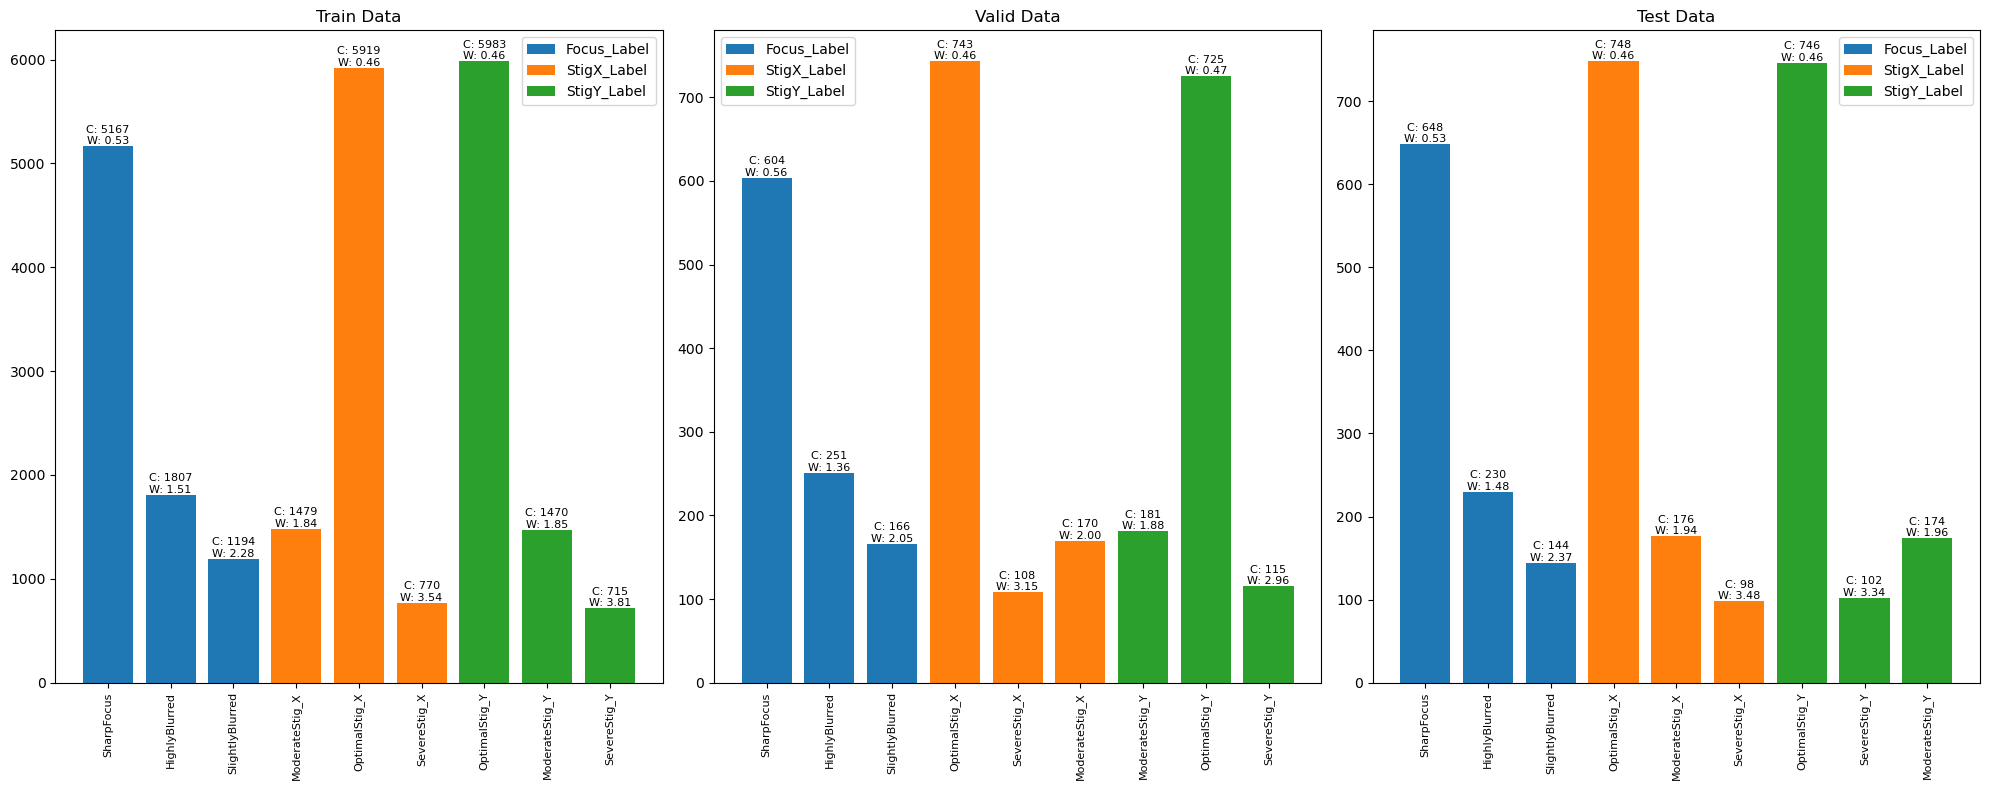

In [768]:
### Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_single_split(ax, df, split, problem_type):
    filtered_df = df.loc[split]
    
    if problem_type == 'Multi-Class':
        labels = filtered_df.index.get_level_values('label').unique()
        all_classes = []
        for label in labels:
            sub_df = filtered_df.loc[label]
            bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")

            for bar, (_, row) in zip(bars, sub_df.iterrows()):
                x = bar.get_x() + bar.get_width() / 2.0
                y = bar.get_height()
                ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}",
                            (x, y), 
                            ha='center', 
                            va='bottom', 
                            fontsize=8)
                
            all_classes.extend(sub_df.index)
        
        ax.legend()
        ax.set_xticklabels(all_classes, rotation=90, fontsize=8)
        ax.set_title(f"{split.capitalize()} Data")
        
    elif problem_type == 'Multi-Label':
        x_ticks = [str(cls) for cls in filtered_df.index]
        bars = ax.bar(x_ticks, filtered_df['Count'])
        
        for bar, (_, row) in zip(bars, filtered_df.iterrows()):
            x = bar.get_x() + bar.get_width() / 2.0
            y = bar.get_height()
            ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                        (x, y), 
                        ha='center', 
                        va='bottom', 
                        fontsize=8)
        
        ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)
        ax.set_title(f"{split.capitalize()} Data")


def plot_dataset_info(df):
    global config
    
    problem_type = config['Experiment']['PROBLEM_TYPE']
    splits = ['train', 'valid', 'test']
    
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split, problem_type)
        
    plt.tight_layout()
    plt.show()


# Assume 'info' is your DataFrame with 'split', 'label', 'class', 'Count', and 'Weight'
# Call the function using your DataFrame
plot_dataset_info(info)


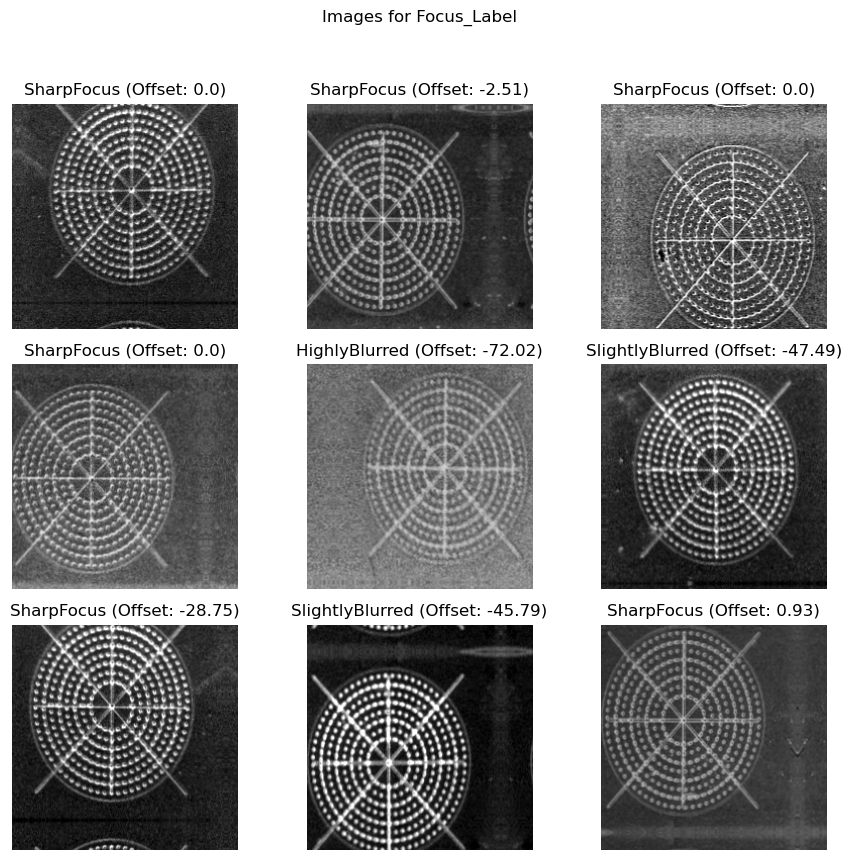

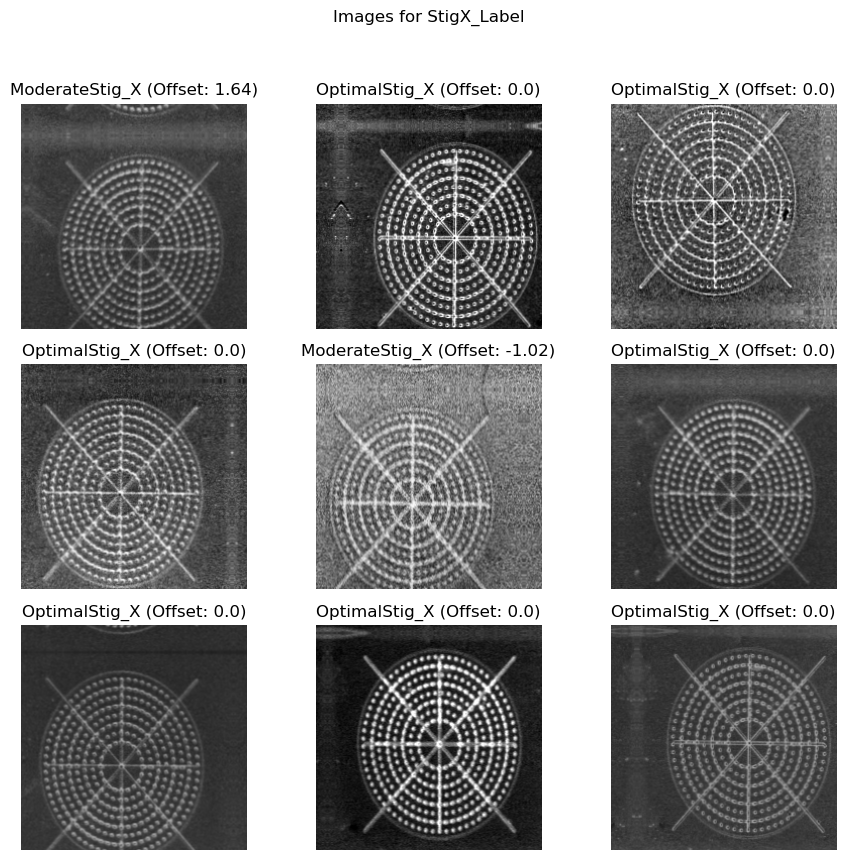

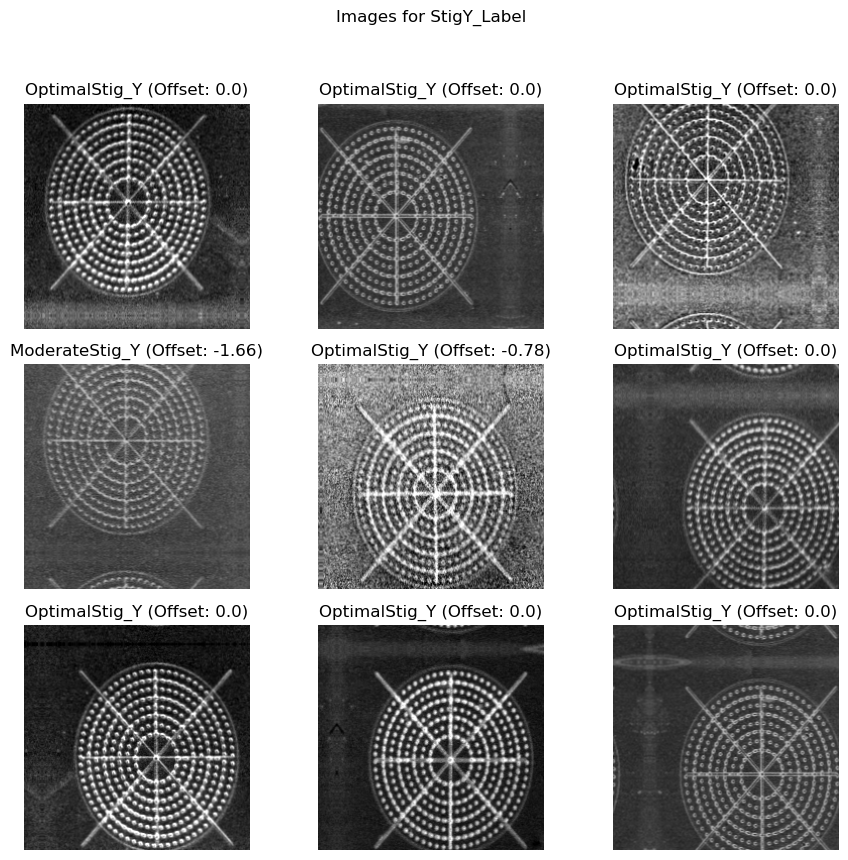

In [769]:
# Assume label_encoders is available
label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']

for label_key in label_keys:
    label_encoder = label_encoders.get(label_key, None)

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.suptitle(f"Images for {label_key}")

    # Take one batch from the training dataset
    for images, labels, offsets in datasets['train'][label_key].take(1):
        # Loop over the batch to plot images, labels, and offsets
        for i in range(min(len(images), 9)):  # Show up to 9 images
            ax = axes[i // 3, i % 3]
            ax.imshow(images[i].numpy())
            
            label_value = labels[i].numpy()
            offset_value = offsets[i].numpy()

            # Use label encoder to get original label name if available
            if label_encoder:
                label_name = label_encoder.inverse_transform([label_value])[0]
            else:
                label_name = label_value
            
            ax.set_title(f"{label_name} (Offset: {round(offset_value, 2)})")
            ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Defining the Models

In [770]:
# Transfer learning models
def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float) -> keras.Model:
    """Creates a transfer learning model based on a given base model."""
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
        
    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)

In [771]:
# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    model = tf.keras.models.Sequential()

    # Explicitly define the input shape
    model.add(tf.keras.layers.Input(shape=input_shape))

    for _ in range(num_conv_blocks):
        model.add(tf.keras.layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=dense_activation))

    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model


In [772]:
# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activation, units = determine_activation_and_units(num_classes)

    # Dropout and Dense output layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

In [773]:
# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

def determine_activation_and_units(num_classes: int) -> tuple:
    """Determine the activation function and units based on number of classes and problem type from config."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type == 'Multi-Label':
        return "sigmoid", num_classes # Sigmoid converts each score of the final node between 0 to 1 independent of what the other scores are
    elif problem_type == 'Binary' or num_classes == 2:
        return "sigmoid", 1 # Sigmoid converts each score of the final node between 0 to 1 independent of what the other scores are
    elif problem_type == 'Multi-Class':
        return "softmax", num_classes # Softmax converts each score of the final node between 0 to 1, but also makes sure all the scores add up to 1
    else:
        raise ValueError(f"Invalid problem_type: {problem_type}")

## Define the Callbacks

In [774]:
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard

# Constants and Configurations
BASE_DIR = os.path.expanduser("~")
MODELS_DIR_NAME = "models"
LOG_DIR_NAME = "logs/fit"
MODEL_CONFIGS = {
    'mobilenetv2': {'model_fn': create_mobilenetv2_transfer_model},
    'small_xception': {'model_fn': create_small_xception_model},
    'basic_cnn': {'model_fn': create_basic_cnn_model},
    'inceptionv3': {'model_fn': create_inceptionv3_transfer_model},
    'resnet50': {'model_fn': create_resnet50_transfer_model}
}


def initialize_model_configs():
    """Initialize model configurations with default values."""
    for config_name in MODEL_CONFIGS:
        input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
        num_classes = len(next(iter(config['Labels']['MAPPINGS'].values())))

        MODEL_CONFIGS[config_name].setdefault('input_shape', input_shape)
        MODEL_CONFIGS[config_name].setdefault('num_classes', num_classes)


def get_metrics_based_on_problem_type(num_classes: int, problem_type: str) -> List[str]:
    """Generate a list of metrics based on the problem type."""
    metrics = []
    
    if problem_type == 'Binary':
        metrics.append('binary_accuracy')
    elif problem_type == 'Multi-Class':
        metrics.append('accuracy')
    elif problem_type == 'Multi-Label':
        metrics.append('categorical_accuracy')
    else:
        raise ValueError("Invalid problem type specified.")
    
    for i in range(num_classes):
        metrics.extend([
            TruePositives(name=f"true_positives_class_{i}"),
            FalsePositives(name=f"false_positives_class_{i}"),
            TrueNegatives(name=f"true_negatives_class_{i}"),
            FalseNegatives(name=f"false_negatives_class_{i}"),
            Precision(name=f"precision_class_{i}"),
            Recall(name=f"recall_class_{i}"),
            AUC(name=f"auc_class_{i}")
        ])
    
    return metrics


def create_directory(path: str) -> None:
    """Create directory if it doesn't exist."""
    os.makedirs(path, exist_ok=True)


def generate_log_and_checkpoint_dirs(model_name: str, label_column: str) -> Tuple[str, str]:
    """Generate directories for logs and checkpoints based on the experiment name."""
    experiment_name = config['Experiment']['NAME']
    model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME, experiment_name, f"{label_column}_models", f"{model_name}_models")
    create_directory(model_dir)

    log_dir = os.path.join(model_dir, LOG_DIR_NAME, f"{model_name}_{datetime.now().strftime('%Y%m%d-%I%M%S%p')}")
    create_directory(log_dir)

    checkpoint_filename = f'model-{datetime.now().strftime("%Y%m%d-%I%M%S%p")}-{{epoch:02d}}-loss{{val_loss:.2f}}-acc{{val_accuracy:.2f}}.h5'
    checkpoint_path = os.path.join(model_dir, checkpoint_filename)

    return log_dir, checkpoint_path


def define_callbacks(model_name: str, label_column: str) -> List[keras_callbacks.Callback]:
    """Define a list of callbacks for model training."""
    log_dir, checkpoint_path = generate_log_and_checkpoint_dirs(model_name, label_column)
    return [
        keras_callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        keras_callbacks.EarlyStopping(monitor='val_loss', patience=config['Model']['EARLY_STOPPING_PATIENCE']),
        keras_callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=config['Model']['REDUCE_LR_PATIENCE'], min_lr=config['Model']['MIN_LR']),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]


def initialize_and_compile_models():
    """Initialize and compile models."""
    callbacks = {}
    models = {}
    label_columns = config['Labels']['MAPPINGS'].keys()
    num_classes = len(next(iter(config['Labels']['MAPPINGS'].values())))
    problem_type = config['Experiment']['PROBLEM_TYPE']
    
    config['Model']['METRICS'] = get_metrics_based_on_problem_type(num_classes, problem_type)
    
    for model_name, model_config in MODEL_CONFIGS.items():
        model = select_model(model_name, model_config['input_shape'], model_config['num_classes'])
        model.compile(
            optimizer=keras.optimizers.Adam(config['Model']['LEARNING_RATE']),
            loss=config['Model']['LOSS'],
            metrics=config['Model']['METRICS']
        )
        
        for label_column in label_columns:
            callbacks_key = f"{model_name}_{label_column}"
            callbacks[callbacks_key] = define_callbacks(model_name, label_column)
        
        models[model_name] = model

    for model_name, model in models.items():
        print(f"Model: {model_name}")
        model.summary()
        print("\n")
        
    return models, callbacks


# Run Initialization Functions
initialize_model_configs()
models, callbacks = initialize_and_compile_models()

Model: mobilenetv2
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
 5 (GlobalAveragePooling2D)                                      
                                                                 
 dense_60 (Dense)            (None, 128)               163968    
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 128)               0         
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None

## Train the Models

In [775]:
from typing import List, Dict, Any, Optional, Tuple
from collections import defaultdict
from tensorflow.keras import Model, layers
import logging
import os
import pickle
import glob
import tensorflow as tf

logging.basicConfig(level=logging.ERROR)


# ------------------ Data Processing and Utilities ------------------

def convert_labels(dataset: Any, problem_type: str) -> Any:
    if problem_type == 'Multi-Class':
        return dataset.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
    elif problem_type == 'Binary':
        return dataset  # Assuming y is already binary
    return dataset

def process_history(history: Any, phase: str, num_classes: Optional[int] = None) -> Dict[str, Any]:
    """Process training or validation history."""
    basic_metrics = ['loss', 'accuracy']
    class_metrics = ['precision', 'recall', 'auc']
    prefix = 'val_' if phase == 'validation' else ''
    
    processed_metrics = {
        metric: history.history.get(f"{prefix}{metric}", []) 
        for metric in basic_metrics
    }
    
    if num_classes:
        for metric_base in class_metrics:
            for i in range(num_classes):
                metric_name = f"{metric_base}_class_{i}"
                processed_metrics[metric_name] = history.history.get(f"{prefix}{metric_name}", [])
    
    return processed_metrics

def defaultdict_to_dict(d: defaultdict) -> dict:
    """Convert a nested defaultdict to a nested dictionary."""
    if isinstance(d, defaultdict):
        d = {k: defaultdict_to_dict(v) for k, v in d.items()}
    return d

def save_results_to_pickle(results: dict):
    """Save the results dictionary to a pickle file."""
    results_dict = defaultdict_to_dict(results)
    results_pickle_path = f'training_results_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl'
    with open(results_pickle_path, 'wb') as f:
        pickle.dump(results_dict, f)
    print(f"Results saved to {results_pickle_path}")


# ------------------ Model Utilities ------------------

def get_latest_checkpoint(model_dirs: List[str]) -> Optional[str]:
    """Return the latest checkpoint file from given model directories."""
    for model_dir in model_dirs:
        list_of_files = glob.glob(os.path.join(model_dir, '*.h5'))
        
        if not list_of_files:
            print(f"No checkpoint files found in {model_dir}.")
            continue
        
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
        print(f"Found {len(list_of_files)} checkpoint files in {model_dir}.")
        print(f"Resuming from the latest checkpoint: {latest_checkpoint}.")
        return latest_checkpoint
    
    print("No checkpoints found in any of the specified directories.")
    return None

def train_and_evaluate_single_model(model: Model, model_name: str, label_column: str, 
                                    train_ds: Any, valid_ds: Any, config: Dict[str, Any], 
                                    callbacks: Any, initial_epoch: int = 0) -> Tuple[Dict[str, Any], Dict[str, Any]]:
    train_weights_dict = {config['Labels']['MAPPINGS'][label_column][key]: value['Weight'] for key, value in train_weights.items()}
    train_cb_key, valid_cb_key, _ = update_callback_keys(label_column, model_name)
    history = train_model(model, train_ds, valid_ds, config, train_weights_dict, callbacks[train_cb_key], initial_epoch=initial_epoch)
    return process_history(history, 'training'), process_history(history, 'validation')


# ------------------ Main Training Loop ------------------

def train_and_evaluate_all_models(model_names: List[str], label_columns: List[str], datasets: Dict[str, Any], 
                                  models: Dict[str, Model], config: Dict[str, Any], 
                                  callbacks: Any, results: Optional[Dict[str, Any]] = None):
    problem_type = config['Experiment'].get('PROBLEM_TYPE', 'Multi-Class')
    
    if results is None:
        results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    
    for label_column in label_columns:
        train_weights = datasets['info']['Training'][label_column]['ClassInfo']
        
        for model_name in model_names:
            model = models.get(model_name, None)
            if model is None:
                continue
            
            train_ds, valid_ds, test_ds = (datasets[ds_type][label_column] for ds_type in ['train', 'valid', 'test'])
            train_ds, valid_ds, test_ds = (convert_labels(ds, problem_type) for ds in [train_ds, valid_ds, test_ds])
            
            base_model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME)
            model_dirs = [
                os.path.join(base_model_dir, exp_name, f"{label_column}_models", f"{model_name}_models")
                for exp_name in ["default_experiment", "binary_classification_v1"]
            ]
            
            latest_checkpoint, prev_results = load_checkpoint_and_results(model, model_dirs)
            
            if latest_checkpoint:
                model = load_or_adapt_model(model, latest_checkpoint, expected_output_units=3)
                if prev_results:
                    results = prev_results
            
            train_results, valid_results = train_and_evaluate_single_model(
                model, model_name, label_column, train_ds, valid_ds, config, callbacks
            )
            results[model_name][label_column]['training'] = train_results
            results[model_name][label_column]['validation'] = valid_results
            
            evaluation_results = evaluate_model(model, test_ds, config)
            print(f'{model_name} on train - Test Loss: {evaluation_results[0]:.4f}, Test Accuracy: {evaluation_results[1]*100:.2f}%')
            
    save_results_to_pickle(results)

# Execute the main loop
results = None  # Or initialize with some existing data if available.
model_names = ["mobilenetv2", "small_xception", "basic_cnn", "inceptionv3", "resnet50"]
label_columns = ["Focus_Label", "StigX_Label", "StigY_Label"]
train_and_evaluate_all_models(model_names, label_columns, datasets, models, config, callbacks, results=results)


KeyError: 'info'